#  Code for 2D staggered Lagrangian method in Cartersian coordinates

## Control equations

一般形式下，弹塑性流体控制方程为：

质量方程：
\begin{equation}
  \frac{dm}{dt}=0
  \end{equation}
动量方程：
\begin{equation}
  \frac{d\rho \mathbf{u}}{dt}= \nabla \cdot  \mathbf{\Pi} 
\end{equation}

能量方程：
\begin{equation}
 \rho \frac{de}{dt}= \mathbf{\sigma} \cdot \mathbf{\varepsilon}
\end{equation}

\section{二维控制方程}

运动方程：
\begin{equation}
  \frac{d(r,z)}{dt}=(u,v)
\end{equation}

质量守恒：
\begin{equation}\label{eq:38}
  \frac{dm}{dt}=0
\end{equation}

动量守恒方程：
\begin{equation}\label{eq:3}
  \begin{array}{l}
	\displaystyle \rho \frac{du}{dt}=\frac{\partial \sigma _{rr}}{\partial r}+ \frac{\partial s_{rz}}{\partial z}\\[0.3cm]
  \displaystyle \rho \frac{dv}{dt}=\frac{\partial \sigma _{zz}}{\partial z}+ \frac{\partial s_{rz}}{\partial r}\\
  \end{array}
  \end{equation}

能量守恒方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \rho \frac{de}{dt}=\sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+s_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle = -p\frac{dV}{dt}+ s_{rr}\frac{\partial u}{\partial r}+s_{zz}\frac{\partial v}{\partial z}+s_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)\\
	\end{array}
	\end{equation}

本构方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \frac{ds_{rr}}{dt}=2\mu \left(\frac{\partial u}{\partial r}-\frac{1}{3}\nabla \cdot \vec{u} \right) +s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{zz}}{dt}=2\mu \left(\frac{\partial v}{\partial z}-\frac{1}{3}\nabla \cdot \vec{u} \right) -s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{rz}}{dt}=\mu \left(\frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right) + \frac{s_{rr}-s_{zz}}{2}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\
  \end{array}
  \end{equation}

Von Mises屈服条件：
\begin{equation}
  \frac{3}{2}(s_{rr}^2+s_{zz}^2+s_{\theta \theta}^2+2s_{xy}^2)\le (Y^0)^2
\end{equation}







$$ s_{\theta\theta} = - (s_{rr} +s_{zz}) $$

## Compatible Staggered Discretization

<img src="Grid.png" width = "800" height = "400" div align=center /> 

<img src="cellpoint.png" width = "800" height = "400" div align=center />

### Quatities:

On point: ($x_p$,$y_p$), ($u_p$,$v_p$)

Zonal:  $V_z$, $\rho_z$, $m_z$, $e_z$, $p_z$

By the relation 
$$\frac{dm_z}{dt} =0$$
we have 
$$\rho_z(t) = m_z/V_z(t)$$

Also 
$$d(x_p)/dt = u_p, \quad d(y_p)/dt = v_p$$

In [3]:
struct Const
    Y0 ::Float64 #Yielding strength
    ρ0 ::Float64 
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end


In [4]:
mutable struct Var
    r::Array{Float64,1}
    z::Array{Float64,1}
    u::Array{Float64,1}
    v::Array{Float64,1}
    ρ::Array{Float64,1}
    p::Array{Float64,1}
    s::Array{Float64,2} # σ[1] = σrr σ[2] = σzz σ[3] = σrz
end    

In [5]:
struct prb
    tt::Float64
    sf::Float64
end

### Point mass 

Point mass $m_p$ is used to solve point momentum $\mu_p = m_p \bf{u}_p$ and kinetic energy $K_p = m_p \frac{\bf{u}_p^2}{2}$

<img src="Ins.jpg" width = "200" height = "400" div align=center /> 

$$m_p = \sum_{z\in Z(p)} A_z^p \rho^p_z$$

$$\rho_z(t) = m_z/V_z(t)$$

In [6]:
function MassAndDens(mz::Array{Float64,1},x::Array{Float64,1},y::Array{Float64,1})
    
    Ic, = size(mz)
    Ip, = size(Tc)
    Asbz = zeros(Float64,4)
    ρ = zeros(Float64,Ic)
    mp = zeros(Float64,Ip)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    for i in 1:Ic
        xz[1:4] = x[Tp[i,1:4]]
        yz[1:4] = y[Tp[i,1:4]]
        Asbz = A_z(xz,yz)
        Az = sum(Asbz)
        ρ[i] = mz[i]/Az
        
        for j = 1:4
            ip = Tp[i,j]
            mp[ip] = mp[ip] + Asbz[j]*ρ[i]
        end
    end
   # @show mp
    return ρ,mp   
end

MassAndDens (generic function with 1 method)


$$ A_z^1 = \frac{5A_{41}+5A_{12}+A_{23}+A_{34}}{12}$$
$$ A_z^2 = \frac{A_{41}+5A_{12}+5A_{23}+A_{34}}{12}$$
$$ A_z^3 = \frac{A_{41}+A_{12}+5A_{23}+5A_{34}}{12}$$
$$ A_z^4 = \frac{5A_{41}+A_{12}+A_{23}+5A_{34}}{12}$$

In [7]:
function A_z(xz,yz) 
    A =zeros(Float64,4)
    xc= sum(xz[i] for i in 1:4)/4
    yc= sum(yz[i] for i in 1:4)/4
    
    A41 = Area3(xz[4],xz[1],xc,yz[4],yz[1],yc)
    A12 = Area3(xz[1],xz[2],xc,yz[1],yz[2],yc)
    A23 = Area3(xz[2],xz[3],xc,yz[2],yz[3],yc)
    A34 = Area3(xz[3],xz[4],xc,yz[3],yz[4],yc)

    A[1] = (5A41+5A12+A23+A34)/12
    A[2] = (A41+5A12+5A23+A34)/12
    A[3] = (A41+A12+5A23+5A34)/12
    A[4] = (5A41+A12+A23+5A34)/12
    
#    A[1] = (A41+A12+A23+A34)/4
#    A[2] = (A41+A12+A23+A34)/4
#    A[3] = (A41+A12+A23+A34)/4
#    A[4] = (A41+A12+A23+A34)/4
    
    return A
end

A_z (generic function with 1 method)

<img src="n12.png" width = "300" height = "300" div align=center />

$$\overrightarrow{n}_{12} = \frac{1}{L_{12}}(y_2- y_1, x_1-x_2)  $$

$$\overrightarrow{\tau}_{12} = \frac{1}{L_{12}}(x_2- x_1, y_2-y_1)  $$

$$ \mathbf{F_1}  = \frac{1}{2}  \left[ -\sigma_{rr}(z_2-z_4)+ s_{rz}(r_2 -r_4), \sigma_{zz}(r_2-r_4) +s_{rz}(z_4 -z_2) , \right] $$ 

In [8]:
function force_zone(x,y,u,v,ρ,p,σ) #(r,z)
   
    Fx = zeros(Float64,4)
    Fy = zeros(Float64,4)
    
    
    Fx[1] = 0.5(σ[1]*(y[4] - y[2]) + σ[3]*(x[2] - x[4]))
    Fy[1] = 0.5(σ[3]*(y[4] - y[2]) + σ[2]*(x[2] - x[4]))
    
    Fx[2] = 0.5(σ[1]*(y[1] - y[3]) + σ[3]*(x[3] - x[1]))
    Fy[2] = 0.5(σ[3]*(y[1] - y[3]) + σ[2]*(x[3] - x[1]))
    
    Fx[3] = 0.5(σ[1]*(y[2] - y[4]) + σ[3]*(x[4] - x[2]))
    Fy[3] = 0.5(σ[3]*(y[2] - y[4]) + σ[2]*(x[4] - x[2]))
    
    Fx[4] = 0.5(σ[1]*(y[3] - y[1]) + σ[3]*(x[1] - x[3]))
    Fy[4] = 0.5(σ[3]*(y[3] - y[1]) + σ[2]*(x[1] - x[3]))
      
    ex,ey = hourglass_viscosity(x, y, u, v, ρ, p,σ) 

    Fx = Fx .+ ex
    Fy = Fy .+ ey
    
    return Fx,Fy
end           

force_zone (generic function with 1 method)

\begin{equation}
  \begin{aligned}
	&\displaystyle \rho \frac{de}{dt}= \mathbf{\sigma} \cdot \mathbf{\varepsilon}\\ 
	&=
	\sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+\sigma_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)
	\end{aligned}
	\end{equation}
    
\begin{equation}
  \begin{aligned}
	&\displaystyle M \frac{de}{dt}=  
\int_{\Omega} \sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+\sigma_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)d\Omega
	\end{aligned}
	\end{equation}


\begin{equation}
  \begin{aligned}
\int_{\Omega}  \frac{\partial u}{\partial r} d\Omega&=  -\oint_{\partial \omega}u dz\\
  &= \frac{1}{2} \left((u_1-u_3)(z_2-z_4)+(u_2-u_4)(z_3-z_1)\right)
  \end{aligned}
\end{equation}

\begin{equation}
  \begin{aligned}
\int_{\Omega}  \frac{\partial u}{\partial z} d\Omega&= \oint_{\partial \omega}u dy\\
  &= -\frac{1}{2} \left((u_1-u_3)(r_2-r_4)+(u_2-u_4)(r_3-r_1)\right)
  \end{aligned}
\end{equation}

$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 

对于节点
$$ \rho \frac{d \mathbf{u}}{dt} = - \nabla p$$

$$m_p \frac{d\bf{u}_p}{dt} = \sum_{p\in P(z)} \bf{F}_z^p$$

$$F_z^1 = \mathbf{F}_1 + c\mathbf{e}_1$$

本构方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \frac{ds_{rr}}{dt}=2\mu \left(\frac{\partial u}{\partial r}-\frac{1}{3}\nabla \cdot \vec{u} \right) +s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{zz}}{dt}=2\mu \left(\frac{\partial v}{\partial z}-\frac{1}{3}\nabla \cdot \vec{u} \right) -s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{rz}}{dt}=\mu \left(\frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right) - \frac{s_{rr}-s_{zz}}{2}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\
  \end{array}
  \end{equation}

Von Mises屈服条件：
\begin{equation}
  \frac{3}{2}(s_{rr}^2+s_{zz}^2+s_{\theta \theta}^2+2s_{xy}^2)\le (Y^0)^2
\end{equation}


In [9]:
function rhs(var::Var)
    μ = con1.μ
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ic, = size(Tp)
    Ip, = size(Tc)
    rhsu = zeros(Float64,Ip)
    rhsv = zeros(Float64,Ip) 
    rhse = zeros(Float64,Ic)
    rhss = zeros(Float64,Ic,3)
    σ = zeros(Float64,Ic,3)
  
    σ[:,1] = s[:,1] - p[:]
    σ[:,2] = s[:,2] - p[:]
    σ[:,3] = s[:,3] 
    
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
    
    for i in 1:Ic
        for j =1:4
            rcell[j] = r[Tp[i,j]]
            zcell[j] = z[Tp[i,j]]
            ucell[j] = u[Tp[i,j]]
            vcell[j] = v[Tp[i,j]]
        end
        Az = sum(A_z(rcell,zcell))
        Fx,Fy = force_zone(rcell,zcell,ucell,vcell,ρ[i],p[i],σ[i,1:3])  
        ∂u_∂r,∂u_∂z = ∂uv(rcell,zcell, ucell)
        ∂v_∂r,∂v_∂z = ∂uv(rcell,zcell, vcell)
        rhse[i] = σ[i,1]*∂u_∂r + σ[i,2]*∂v_∂z+σ[i,3]*(∂u_∂z + ∂v_∂r)
        for j = 1:4
            ip = Tp[i,j]
            rhsu[ip] +=  Fx[j]
            rhsv[ip] +=  Fy[j]
        end  
        ∇u = ∂u_∂r + ∂v_∂z
    
        rhss[i,1] =  (2μ*(2/3*∂u_∂r - 1/3*∂v_∂z) + σ[i,3]*(∂u_∂z - ∂v_∂r)) ./Az
        rhss[i,2] =  (2μ*(2/3*∂v_∂z - 1/3*∂u_∂r) - σ[i,3]*(∂u_∂z - ∂v_∂r)) ./Az
        rhss[i,3] =   (μ*(∂u_∂z+∂v_∂r)  -   (σ[i,1] - σ[i,2])*(∂u_∂z - ∂v_∂r)) ./Az      
    end

    return rhse, rhsu,rhsv,rhss

end     

rhs (generic function with 1 method)

In [10]:
function output(f)
    io = open("data2.dat", "w+")
     writedlm(io,f,"  ") 
    close(io)
end

output (generic function with 1 method)

$$ \mathbf{S} = \mathbf{S} \times \text{min} \left(1,Y_0/\sqrt{\frac{3}{2}\mathbf{S}:\mathbf{S}}\right)$$

In [11]:
function yield_s!(s,con)
    Y0 = con.Y0
    I, = size(s)
    for i in 1:I
         sums = s[i,1]^2 +s[i,2]^2 +2*s[i,3]^2 +(s[i,1]+s[i,2])^2
        for j = 1:3
       
        s[i,j] = s[i,j] * min(1,Y0/√(3/2*sums))
            end 
    end
    return s
end

yield_s! (generic function with 1 method)

In [12]:
function predictor_corrector2nd(dt,var::Var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,r,z)
    e = p_to_e(ρ, p,con1)    
    p = artificial_viscosity!(r,z,u,v,ρ,p)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r, z, u, v, ρ, p, s)
    
    rhse, rhsu,rhsv,rhss = rhs(var)
    rhsu,rhsv = bound_force(rhsu,rhsv,var)
    
    s = yield_s!(s,con1)
    r₀ =  r + dt*u
    z₀  = z + dt*v
    u₀  = u + dt*(rhsu ./ mp)
    v₀  = v + dt*(rhsv ./ mp)
    e₀  = e + dt*(rhse ./ mz) 
    s₀  = s + dt*rhss
  #  @show rhsu
    s₀ = yield_s!(s₀,con1)
    r₀,z₀,u₀,v₀ = bound_ghost_coordinate!(r₀,z₀,u₀,v₀)
    ρ,mp = MassAndDens(mz,r₀,z₀)
    p = e_to_p(ρ,e₀,con1)
    p = artificial_viscosity!(r₀,z₀,u₀,v₀,ρ,p) 
    ρ,p,s₀ = bound_ghost_cell!(ρ,p,s₀)
    var = Var(r₀, z₀, u₀, v₀, ρ, p, s₀)
   
    rhse₀,rhsu₀,rhsv₀,rhss₀ = rhs(var)
    rhsu₀,rhsv₀ = bound_force(rhsu₀,rhsv₀,var)
  #  @show s[:,1]
    r +=  0.5dt*(u + u₀)
    z +=  0.5dt*(v + v₀)
    u +=  0.5dt*(rhsu + rhsu₀) ./ mp
    v +=  0.5dt*(rhsv + rhsv₀) ./ mp
    e +=  0.5dt*(rhse + rhse₀) ./ mz
    s  += 0.5dt*(rhss + rhss₀)
    s = yield_s!(s,con1)
    r,z,u,v = bound_ghost_coordinate!(r,z,u,v)
    ρ,mp = MassAndDens(mz,r,z)
    p = e_to_p(ρ,e,con1)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r,z,u,v,ρ,p,s)
   
    return var
end

predictor_corrector2nd (generic function with 1 method)

In [13]:
function fη(ρ,c::Const)
    η = ρ/c.ρ0
    fη=(η .-1.0) .* (η .-c.Γ0*(η .-1.0)/2.0) ./ (η .-c.s0*(η .-1)) .^2
end

function fηη(ρ,c::Const)
    η = ρ/c.ρ0
    fηη=(η .+(c.s0-c.Γ0) .* (η .-1)) ./(η .-c.s0*(η .- 1)) .^3
end

fηη (generic function with 1 method)

In [14]:
function euler1st(dt,var::Var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,r,z)
    e = p_to_e(ρ, p,con1)    
    p = artificial_viscosity!(r,z,u,v,ρ,p)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r, z, u, v, ρ, p, s)
    
    rhse, rhsu,rhsv,rhss = rhs(var)
    rhsu,rhsv = bound_force(rhsu,rhsv,var)
    
 #   @show rhsv
    s = yield_s!(s,con1)
    r =  r + dt*u
    z = z + dt*v
    u  = u + dt*(rhsu ./ mp)
    v  = v + dt*(rhsv ./ mp)
    e  = e + dt*(rhse ./ mz) 
    s  = s + dt*rhss
  #  @show rhsu
    s = yield_s!(s,con1)
    r,z,u,v = bound_ghost_coordinate!(r,z,u,v)
    ρ,mp = MassAndDens(mz,r,z)
    p = e_to_p(ρ,e,con1)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r,z,u,v,ρ,p,s)
   
    return var
end

euler1st (generic function with 1 method)

### Boundary force

If one edge of a cell is a free boundary, then $f$ on the points is zero. As we have add it in RHs(), we need to remove it by resolve it again. Different from RHs(), at every point of a cell the force is composited by two parts on different edges. This is distinguished by $k$ when $k = 1$ the boundary is on y direction, forces on 12 and 34 boundary must be subtracted. When $ k =2$ the boundary is on x direction, subtract forces on 41, 23. 

In [56]:
function bound_force(rhsu,rhsv,var)
    Ip, = size(Tc)
    Ib, = size(Tb)
   
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
    ip1 = zeros(Int,4)
    σ = zeros(Float64,3)
    for i in 1:Ib
        if Tb[i,4] == 1 || Tb[i,4] == 3
            ic = Tb[i,1]        
            rcell[1:4] = r[Tp[ic,1:4]]
            zcell[1:4] = z[Tp[ic,1:4]]
            ucell[1:4] = u[Tp[ic,1:4]]
            vcell[1:4] = v[Tp[ic,1:4]]

            σ[1] = s[ic,1] - p[ic]
            σ[2] = s[ic,2] - p[ic]
            σ[3] = s[ic,3]

            ex,ey = hourglass_viscosity(rcell, zcell, ucell, vcell, ρ[ic]
                                        , p[ic],s[ic,:])
            i₁ = Tb[i,3]
            i₂ = i₁+1
            if i₁ == 4
                i₂ = 1
            end
            nx = zcell[i₂] -zcell[i₁]
            ny = rcell[i₁] -rcell[i₂]
            p0 = 1e-10
            for j in (i₁,i₂)

                ip = Tp[ic,j]
                    Fx = -σ[1]*nx/2 -σ[3]*ny/2+ex[j] #*nx^2/(nx^2+ny^2)  #+ex[j] 
                    Fy = -σ[3]*nx/2 -σ[2]*ny/2+ey[j] #*ny^2/(nx^2+ny^2)
                    Fx1 = (Fx*nx+Fy*ny)*nx/(nx^2+ny^2)
                    Fy1 = (Fx*nx+Fy*ny)*ny/(nx^2+ny^2)
                    Fx = Fx- Fx1
                    Fy = Fy - Fy1
                    Fx1 =  p0*nx/2 #+ex[j]*nx^2/(nx^2+ny^2) 
                    Fy1 =  p0*ny/2 #+ey[j]*ny^2/(nx^2+ny^2)

                #    rhsu[ip] +=  -Fx1 # -Fx1
                #    rhsv[ip] +=  -Fy1 #-Fy1

                if Tb[i,4] == 3 # boundary
                    uL = 2e-3
                    u[ip] = uL #*nx/(nx^2 +ny^2)
                end  
            end
        end
    end 

    return rhsu, rhsv
end  

bound_force (generic function with 1 method)

<img src="bound_corresponding.png" width = "400" height = "800" div align=center /> 

$$ Ig_1 = Tb[i,3] $$
$$Ib_1 = Ig_1 -1$$

In [16]:
function bound_ghost_coordinate!(r,z,u,v)
    Ip, = size(Tc)
    Ic, = size(Tp)
    Ib, = size(Tb)
   # r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
   
    rt= copy(r)
    zt= copy(z)
   # output(r)
    for i in 1:Ib
        if Tb[i,4] == 2
            ic = Tb[i,1]
            ic2= Tb[i,2]
            ig₁ = Tb[i,3]
            
           
            ig₁ == 4 ? ig₂ = 1 : ig₂ = ig₁+1
            ig₂ == 4 ? ig₃ = 1 : ig₃ = ig₂+1
            ig₃ == 4 ? ig₄ = 1 : ig₄ = ig₃+1

            ig₁ == 1 ? ib₁ = 4 : ib₁ = ig₁-1
            ib₁ == 1 ? ib₂ = 4 : ib₂ = ib₁-1
            ib₂ == 1 ? ib₃ = 4 : ib₃ = ib₂-1
            ib₃ == 1 ? ib₄ = 4 : ib₄ = ib₃-1

                r1 =    rt[Tp[ic2,ib₁]]
                r2 =    rt[Tp[ic2,ib₂]]
                z1 =    zt[Tp[ic2,ib₁]]
                z2 =    zt[Tp[ic2,ib₂]]

                r3=     rt[Tp[ic2,ib₃]]
                z3=     zt[Tp[ic2,ib₃]]
                r4=     rt[Tp[ic2,ib₄]]
                z4=     zt[Tp[ic2,ib₄]]
                
                nx = zt[Tp[ic2,ib₁]] -zt[Tp[ic2,ib₂]]
                ny = rt[Tp[ic2,ib₂]] -rt[Tp[ic2,ib₁]]
                for j in (ib₁,ib₂)
                    ip = Tp[ic2,j]
                    u[ip] = u[ip]*ny^2/(nx^2 +ny^2)
                    v[ip] = v[ip]*nx^2/(nx^2 +ny^2)
                end

                r[Tp[ic,ig₃]],z[Tp[ic,ig₃]] = reflect(r1,z1,r2,z2,r3,z3)
                r[Tp[ic,ig₄]],z[Tp[ic,ig₄]] = reflect(r1,z1,r2,z2,r4,z4)
                u[Tp[ic,ig₃]],v[Tp[ic,ig₃]] = u[Tp[ic2,ib₃]],v[Tp[ic2,ib₃]]
                u[Tp[ic,ig₄]],v[Tp[ic,ig₄]] = u[Tp[ic2,ib₄]],v[Tp[ic2,ib₄]]
            
       
          end 
    end
    return r,z,u,v
end  

bound_ghost_coordinate! (generic function with 1 method)

In [17]:
function bound_ghost_cell!(ρ,p,s)
    Ip, = size(Tc)
    Ic, = size(Tp)
    Ib, = size(Tb)    
    for i in 1:Ib
        if Tb[i,4] == 2
            ic = Tb[i,1]
            ic2= Tb[i,2]
            ρ[ic] = ρ[ic2]
            p[ic] = p[ic2]
            s[ic,1:2] = s[ic2,1:2]
            s[ic,3] = -s[ic2,3]
          end 
    end
    return ρ,p,s
end  

bound_ghost_cell! (generic function with 1 method)

In [18]:
exp1[r4]

UndefVarError: UndefVarError: exp1 not defined

## Ghost cell coordinate of a reflect boundary

<img src="reflect.png" width = "200" height = "400" div align=center /> 

$$ k_1 k_2 = -1$$
$$ d_3 = -d_4 $$

$$(z_2-z_1)(z_3-z_4)+(r_3-r_4)(r_2-r_1) = 0$$
$$(z_2-z_1)(r_3-r_1)-(z_3-z_1)(r_2-r_1) = -(z_2-z_1)(r_4-r_1)+(z_4-z_1)(r_2-r_1)$$

In [19]:
using SymPy
@vars z1 z2 z3 z4 r1 r2 r3 r4
exp1 = solve([(z2-z1)*(z3-z4)+(r2-r1)*(r3-r4),(z2-z1)*(r3-r1)-(z3-z1)*(r2-r1)+(z2-z1)*(r4-r1)-(z4-z1)*(r2-r1)],[r4,z4])
@show exp1[r4],exp1[z4]

(exp1[r4], exp1[z4]) = (((r1 - r2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3) - (z1 - z2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2))/((r1 - r2)^2 + (z1 - z2)^2), ((r1 - r2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2) + (z1 - z2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3))/((r1 - r2)^2 + (z1 - z2)^2))


(((r1 - r2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3) - (z1 - z2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2))/((r1 - r2)^2 + (z1 - z2)^2), ((r1 - r2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2) + (z1 - z2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3))/((r1 - r2)^2 + (z1 - z2)^2))

In [20]:
function reflect(r1,z1,r2,z2,r3,z3)
    tmp1=(r1*r3-r2*r3+z1*z3-z2*z3) 
    tmp2 = (2r1*z2-r1*z3-2r2*z1+r2*z3+r3*z1-r3*z2)
    tmp3 = ((r1-r2)^2+(z1-z2)^2)
    
    r4 = ((r1-r2)*tmp1 - (z1-z2)*tmp2)/tmp3
    z4 = ((r1-r2)*tmp2 + (z1-z2)*tmp1)/tmp3
    
    return r4,z4
end

reflect (generic function with 1 method)

In [21]:
reflect(1,1,1,0,0.9,0)

(1.1, 0.0)

### EOS 
$$ e = \frac{p}{(\gamma-1)\rho}$$

In [22]:
function p_to_e(ρ,p,con)
    c=con
    ei = (p .- c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function e_to_p(ρ,ei,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei .+ c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

e_to_p (generic function with 1 method)

In [23]:
function CFL(SF,var)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ic, = size(ρ)
    cflmin = 1.e9
      cfl = 0 
    for i in 1:Ic
        cfl =0
        u2max = 0
        u2=0.0
        for j = 1:4
            ip = Tp[i,j]
            u2 = u[ip]^2+v[ip]^2
            if u2 > u2max ; u2max = u2; end
        end
        
        dlmin = (r[Tp[i,4]] - r[Tp[i,1]])^2+(z[Tp[i,4]]-z[Tp[i,1]])^2
       
        for j=1:3
            dl= (r[Tp[i,j+1]] - r[Tp[i,j]])^2+(z[Tp[i,j+1]]-z[Tp[i,j]])^2
            if dl < dlmin; dlmin=dl; end
        end
        c = sound([ρ[i],u[i],p[i],min(s[i,1],s[i,2])],con1)
        cfl = √(dlmin)/(√(u2max)+c)
        if cfl < cflmin; cflmin = cfl; end
    end
 #   @show cflmin
    dt = cflmin*SF
    return dt
end 
        

CFL (generic function with 1 method)

In [24]:
function sound(uo::Array{Float64,1},con::Const,EoP::Int=1)
    a0,ρ0,Γ0,Y0,μ  = con.a0,con.ρ0,con.Γ0,con.Y0,con.μ
    ρ,uu,p,sxx   = uo[1:4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
    if EoP == 2
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx)
        return c
    else
       #  @show a2,ρ0/ρ^2,4.0/3*μ/ρ
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
       
        return c
    end
end

sound (generic function with 2 methods)

In [51]:
function TimeSolve(var,mz)
    tt= problem.tt
    sf =problem.sf
    t= 0.0
    t₁ = tt/100
    t₂ = t₁
    kinetic_init,energy_init = total_kinetic(var,mz)
    kinetic = kinetic_init
   # while kinetic > 1e-4*kinetic_init && t<tt
    while t<tt
    
#for i in 1:50
        dt=CFL(sf,var)
   #     @show dt
        if t+dt>tt
           dt = tt-t
        end
        
        var = predictor_corrector2nd(dt,var,mz)
       # var = euler1st(dt,var,mz)
        kinetic,energy = total_kinetic(var,mz)
         t += dt
        if t > t₁
            println(t)
            t₁ += t₂
            @show kinetic/kinetic_init,(energy+kinetic)/(kinetic_init+energy_init)
        end
        
    end
    return var
end

TimeSolve (generic function with 1 method)

In [26]:
function total_kinetic(var,mz)
    r,z,u,v,ρ,p = var.r,var.z,var.u,var.v,var.ρ,var.p
    Ip, = size(Tc)
    Ic, = size(Tp)
    Ib, = size(Tb)
    k = zeros(Float64,Ip)
    
    kinetic = 0
    energy = 0
     ρ1,mp = MassAndDens(mz, r, z)
    
    for i in 1:Ip
        k[i]= mp[i]*0.5*(u[i]^2+v[i]^2)
    end
    
    
    for i in 1:Ic
        energy += mz[i]*p_to_e(ρ[i], p[i], con1)
    end
    
    for i in 1:Ib
        if Tb[i,4] == 2
            ic= Tb[i,1]
            energy -= mz[ic]*p_to_e(ρ[ic], p[ic], con1)
            
            ig₁ = Tb[i,3]
            ig₁ == 4 ? ig₂ = 1 : ig₂ = ig₁+1
            k[Tp[ic,ig₁]] = 0
            k[Tp[ic,ig₂]] = 0
            end
    end
    kinetic = sum(k)
    return kinetic,energy
end


total_kinetic (generic function with 1 method)

## Artificial Viscosity 

Use the strain rate to construct the artificial viscosity 
$$\frac{ds}{dt} = \frac{\partial u}{\partial x}  + \frac{\partial v}{\partial y} $$


Then the artificial viscosity can be written as
$$ q_w = \left\{ \begin{align}
\alpha L \rho \left( \frac{ds}{dt} \right)^2 +  \beta L^2 \rho c \left|\frac{ds}{dt}\right|, \quad \text{if}  \quad \frac{ds}{dt}< 0,\\
0, \quad \text{if} \quad \frac{ds}{dt}\ge 0. \\
\end{align}
\right.
$$
where $\alpha = 0.6$, $\beta = 2.0 $ and $c$ is the sonic speed.

$L$ is the reference length, and constructed as
$$L = A/L_{\text{max}} $$

$$L_{\text{max}} = \text{max}(L_{13},L_{24})$$


In [27]:
function artificial_viscosity_c!(x,y,u,v,ρ,p)
    xc = sum(x[i] for i in 1:4)/4
    yc = sum(y[i] for i in 1:4)/4
    
    ∂u_∂x,tmp = ∂uv(x,y,u)
    tmp,∂v_∂y = ∂uv(x,y,v)
    c = sound([ρ,0.0,p,0.0],con1)
    Lmax = max(√((x[3] - x[1])^2+(y[3] - y[1])^2) ,√((x[2] - x[4])^2+(y[2] - y[4])^2) )  
    A = area_quadrangle(x, y)
    L = A/Lmax 

    if ∂u_∂x + ∂v_∂y> 0
        q = 0
    else
        q = 0.6ρ*L*c*(abs(∂u_∂x+∂v_∂y))/A +2.0L^2*ρ*((∂u_∂x+∂v_∂y)^2)/A^2 
    end
    return p+q
end

artificial_viscosity_c! (generic function with 1 method)

$$b_2 \rho Lc \frac{\partial u}{\partial x} - b_{12}\rho L^2 \left(\frac{\partial u}{\partial x}\right)^2$$

In [28]:
function artificial_viscosity!(r,z,u,v,ρ,p)
    I, = size(Tp)
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
   
    for i in 1:I
        for j in 1:4
            ip = Tp[i,j]
            rcell[j] = r[ip]
            zcell[j] = z[ip]
            ucell[j] = u[ip]
            vcell[j] = v[ip]
        end
        p[i] = artificial_viscosity_c!(rcell,zcell,ucell,vcell,ρ[i],p[i])
    end
    
        return p
        
    end       

artificial_viscosity! (generic function with 1 method)

In [29]:
function l_viscosity(x,y,α)
    xc = sum(x)/4; yc = sum(y)/4
    d = zeros(Float64,4)
    for i in 1:4
    d[i] = distance(x[i],y[i],xc,yc,α)
    end
    A = A_z(x, y)
    L = 2sum(A)/sum(d)
    return L
end

l_viscosity (generic function with 1 method)

#### distance from  Point to line 
Line: $$ (xc -cos \alpha )(x-xc) = (yc-sin \alpha)(y-yc)$$
point: $x,y$

In [30]:
function distance(x,y,xc,yc,α)
    d = abs((xc - cosd(α)) * (x .-xc)- (yc-sind(α))*(y .- yc))/√((xc-cosd(α))^2+(yc-sind(α))^2)
    return d
end

distance (generic function with 1 method)

### 沙漏粘性 Hourglass

$$ \text{hg}_x = u_1 -u_2 + u_3 - u_4$$ 
$$ \text{hg}_x = v_1 -v_2 + v_3 - v_4$$ 

$$ e_{1x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{1y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{2x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{2y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{3x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{3y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{4x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{4y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

In [50]:
function hourglass_viscosity(x,y,u,v,ρ,p,s)
    hgx = u[1] - u[2] + u[3] -u[4]
    hgy = v[1] - v[2] + v[3] -v[4]
    
    ex =zeros(Float64,4)
    ey =zeros(Float64,4)
    A = area_quadrangle(x,y)
    c = sound([ρ,0.0,p,min(s[1],s[2])], con1)
 #   @show c
    q = 0.1 # coefficient of hourglass viscosity 0.01 - 0.5 ?
    ex[1] = -0.25q*ρ*c*√(A)*hgx
    ey[1] = -0.25q*ρ*c*√(A)*hgy
    
    ex[2] = -ex[1]
    ey[2] = -ey[1]
    
    ex[3] = ex[1]
    ey[3] = ey[1]
    
    ex[4] = ex[2]
    ey[4] = ey[2]
    
 # ex .= 0
 # ey .= 0
 #   @show ex,ey
    return ex, ey
end

hourglass_viscosity (generic function with 1 method)

In [32]:
function area_quadrangle(x::Array{Float64,1},y::Array{Float64,1}) 
   
    xc= sum(x[i] for i in 1:4)/4
    yc= sum(y[i] for i in 1:4)/4
    
    A41 = Area3(x[4],x[1],xc,y[4],y[1],yc)
    A12 = Area3(x[1],x[2],xc,y[1],y[2],yc)
    A23 = Area3(x[2],x[3],xc,y[2],y[3],yc)
    A34 = Area3(x[3],x[4],xc,y[3],y[4],yc)
    
    A = A12 + A23 +A34 +A41
    return A
end

area_quadrangle (generic function with 1 method)

In [33]:
function Area3(x1,x2,x3,y1,y2,y3)
    return abs((x1*y2+y1*x3+x2*y3-x1*y3-y1*x2-y2*x3)/2)
end

Area3 (generic function with 1 method)

###  $\frac{\partial (u,v)}{\partial (x,y)}$

we use the diffences between 1 and 3 points and 2 and 4 points to solve the partial differences approximately, as
$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 
Similar process to $\frac{\partial u}{\partial y}$,$\frac{\partial v}{\partial x}$ and $\frac{\partial v}{\partial y}$

In [34]:
function ∂uv(x,y,u)
    ∂u_∂x = 0.5(u[1]-u[3])*(y[2]-y[4]) + 0.5(u[2]-u[4])*(y[3]-y[1])
    ∂u_∂y = -0.5(u[1]-u[3])*(x[2]-x[4]) - 0.5(u[2]-u[4])*(x[3]-x[1])
    return ∂u_∂x,∂u_∂y
end

∂uv (generic function with 1 method)

## Output function

In [35]:
function cell_coordinate(x,y)
    Ip, = size(Tc)
    Ic, = size(Tp)
    xc = zeros(Float64,Ic)
    yc = zeros(Float64,Ic)
    
    for i in 1:Ic
        for j = 1:4
            ip = Tp[i,j] 
            xc[i] += x[ip]/4
            yc[i] += y[ip]/4
        end
        
    end
    
    return xc,yc
end

cell_coordinate (generic function with 1 method)

In [36]:
function outputline(Ix,Iy,var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    I, = size(ρ)
    
    uline =  zeros(Float64,Ix)
    rline =  zeros(Float64,Ix)
    zline =  zeros(Float64,Ix)
    ρline =  zeros(Float64,Ix)        
    pline =  zeros(Float64,Ix)  
    sline = zeros(Float64,Ix,3)
    for i in 1:Ix
        j = Int(floor(Iy/2))
            ip = i+(j-1 ) *(Ix+1)
            ic =i+(j-1)*Ix
            uline[i] = u[ip]
            rline[i]  = r[ip]
            ρline[i]  = ρ[ic]
            pline[i] = p[ic]
           # σline[i,:] .= σ[ic,:]
            sline[i,:] = s[ic,:]
    end
    return rline,uline,ρline,pline,sline
end

outputline (generic function with 1 method)

In [37]:
function Output_cell(Ix,Iy,var,mz)
    x,y,u,v,ρ,p,s= var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data.dat", "w+")
    A = zeros(Float64,Ip,10)
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\" \"s:s\"  ZONE T=\"Zone 1\" 
I=$Ix,J=$Iy,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "

    write(io,text) 
    for i in 1:Ic
        xc = 0
        yc =0
        uc =0
        vc =0
        for j = 1:4
            ip = Tp[i,j] 
                xc += x[ip]/4
                yc += y[ip]/4
                uc += u[ip]/4
                vc += v[ip]/4
        end
        
        A[i,1] = xc
        A[i,2] = yc
        A[i,3] = uc
        A[i,4] = vc
        A[i,5] = ρ[i]        
        A[i,6] = p[i]      
        A[i,7:9] .= s[i,1:3] 
        A[i,10] = (s[i,1]^2+s[i,2]^2 +2s[i,3]^2+(s[i,1]+s[i,2])^2)
    end
      writedlm(io, A, "  ")
    close(io)
end

Output_cell (generic function with 1 method)

In [98]:
function Output_point(Ix,Iy,var,mz)
    x,y,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ip, = size(Tc)
    Ic, = size(Tp)
    
    io = open("data.dat", "w+")
    io2 = open("data2.dat", "w+")
    #s = zeros(Float64,Ip,3)
    A = zeros(Float64,Ip,9)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\"   ZONE T=\"Zone 1\" 
I=$(Ix+1),J=$(Iy+1),K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
      text2 = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\"   ZONE T=\"Zone 1\" 
I=$(Ix),J=1,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)
    write(io2,text2)
       ρp = zeros(Float64,Ip)
       pp = zeros(Float64,Ip)
       np = zeros(Int,Ip)
       sp = zeros(Float64,Ip,3)
    
    for i in 1:Ic
        
        xc = 0
        yc =0
        uc =0
        vc =0
        for j = 1:4
            ip = Tp[i,j] 
            ρp[ip] += ρ[i]
            pp[ip] += p[i]
            sp[ip,:] += s[i,:]
            np[ip] += 1   
        end
    end
        ρp = ρp ./ np
        pp = pp ./ np
        sp = sp ./ np
    
        A[:,1] = x
        A[:,2] = y
        A[:,3] = u
        A[:,4] = v
        A[:,5] = ρp
        A[:,6] = pp
        A[:,7:9] .= sp[:,1:3]
    
      writedlm(io, A, "  ")
        writedlm(io2, A[1:401,:], "  ")
    close(io)
    close(io2)
end

Output_point (generic function with 1 method)

## Cases

In [79]:
 function Piston()

    global problem = prb(1.5e2,0.1)
    # global problem = prb(3e-5,0.3)
     
    I =  100
    J = 5
    dx = 100/I
    dy = 10/J

    I1= I+1
    J1= J+2
    global   con1 = Const(9e-4,8.930,2.0,4.5e-1,0.3940,1.49)
  #  global   con1 = Const(0.0,8930,2.0,4.5e10,3940.0,1.49)
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    

# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 4
            Tb[ib,4] = 3
        end
    
      for i = 1:I1-1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 2
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 2
                end
            end
        end
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 4
             Tb[ib,4] = 2
         end
    
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-2)*dy
            u[ip] = 0
            v[ip] = 0.0
        end
    end
    
      
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y = bound_ghost_coordinate!(x,y,u,v)
  #  x,y = bound_ghost_coordinate!(x,y)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                p[ic] = 1.e-6
                ρ[ic] = 8.930
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0       
        end
    end 
    return var,mz,I1,J1
end

Piston (generic function with 1 method)

In [80]:
var,mz,I,J=Piston()
#Output1
var= TimeSolve(var,mz)

1.6855050411205441
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 1.4491527489998812)
3.1530206148107514
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 1.7810175100004537)
4.617160122941333
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 2.131066513611652)
6.079274328351767
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 2.492995705254943)
7.540259722529125
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 2.8613917561582567)
9.001047439069266
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 3.222621207730077)
10.670503797387243
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 3.6224033976777696)
12.131107579022013
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 3.964436033937492)
13.591373275598139
(kine

103.61535224458049
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 26.39561410532)
105.07371619118479
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 26.753207667880652)
106.53206873187858
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 27.110794496349982)
108.19874334777877
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 27.51945761788166)
109.65707134316844
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 27.877031593536135)
111.11538787106535
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 28.23459947189079)
112.57369295873119
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 28.592161062822317)
114.03198660173273
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (Inf, 28.94971665774978)
115.69859385339399
(kin

Var([0.3, 1.29381, 2.28897, 3.28413, 4.27929, 5.27446, 6.26962, 7.26478, 8.25995, 9.25511  …  92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0], [-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0  …  12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0], [0.00176891, 0.00199646, 0.00199648, 0.00199651, 0.00199651, 0.00199655, 0.00199655, 0.00199659, 0.00199659, 0.00199663  …  9.30435e-7, 5.70729e-7, 3.4426e-7, 2.0408e-7, 1.18597e-7, 6.69475e-8, 3.54957e-8, 1.526e-8, 8.96591e-43, 1.526e-8], [-1.73119e-16, 1.26925e-16, -1.04473e-16, -3.83925e-16, -3.31965e-17, 2.38752e-16, 1.8772e-16, -1.41216e-16, -2.48775e-16, 4.00628e-16  …  2.45992e-15, 1.63166e-16, -7.47951e-16, 2.62352e-15, 1.58499e-15, -8.84087e-16, -1.75205e-15, -3.54943e-15, -3.17367e-15, -3.54943e-15], [8.98566, 8.97342, 8.97341, 8.97341, 8.9734, 8.97339, 8.97339, 8.97339, 8.97339, 8.97339  …  8.93002, 8.93001, 8.93001, 8.93, 8.93, 8.93, 8.93, 8.93, 8.93, 8.93], [0.00800921, 0.00682395, 0.00681998, 0.

In [ ]:
push!(LOAD_PATH,"/home/bfly/workspace/Juliastudy/Src")

In [ ]:
uo,u,x,inter = Lag1DNum.Piston()
uo,x  = Lag1DNum.TimeSolve(uo, x,inter)

In [82]:
rcell, zcell = cell_coordinate(var.r,var.z)

([0.796903, 1.79139, 2.78655, 3.78171, 4.77687, 5.77204, 6.7672, 7.76237, 8.75753, 9.7527  …  91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5, 99.5, 100.5], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0])

In [92]:
using DelimitedFiles
Output_point(I,J,var,mz)

In [66]:
using PyPlot

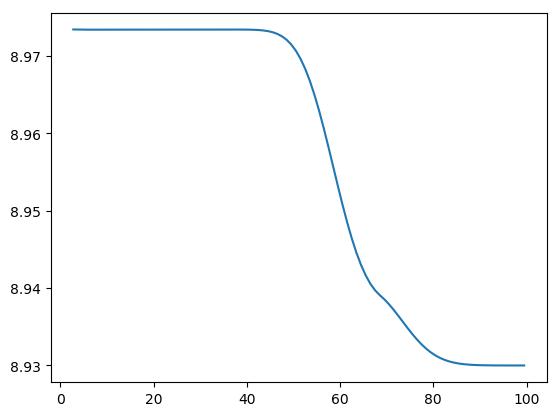

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f97957e9c18>

In [84]:
plot(rcell[3:100],var.ρ[3:100])

In [ ]:
 function Pistonz()

    global problem = prb(1.5e-4,0.3)
    # global problem = prb(3e-5,0.3)
     
    I = 10
    J = 100
    dx = 0.1/I
    dy = 1/J
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
    for i = 1:I+1
        for j = 1:J+1
            if i == 1 || i== I+1 ||  j == 1 || j == J+1
                ib += 1
                ic =i+(j-1)*I
                #ic = Tc[ip]
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4 # 1->4 
                    Tb[ib,3] = 2 # type 1:free 2:
                end   
                 if  i==I+1 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 2
                end
            
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J+1
                    Tb[ib,2] = 3 
                    Tb[ib,3] = 1
                end
            end
        end
    end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    σ = zeros(Float64,Ic,3)
    
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-1)*dy
            u[ip] = 0
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e5
                ρ[ic] = 8930
                mz[ic] = ρ[ic] * Az[ic]
                σ[ic,1] = -p[ic]
                σ[ic,2] = -p[ic]
                σ[ic,3]= 0 
#             else
#                 mz[ic] = 1.0 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 1.0
#             end
        end
    end
    var = Var(x,y,u,v,ρ,p,σ)
    return var,mz,I,J
end

In [ ]:
var,mz,I,J=Pistonz()
#Output1
var = TimeSolve(var,mz)

In [ ]:
rcell, zcell = cell_coordinate(var.r,var.z)

In [ ]:
plot3D(var.r,var.z,var.v)
#triplot()

In [ ]:
tricontourf(var.r,var.z,var.v)

In [ ]:
? Const

In [95]:
 function Wilkins()

    global problem = prb(5,0.1)
    # global problem = prb(3e-5,0.3)
     
    I =  400
    J = 4
    dx = 5/I
    dy = 0.05/J

    I1= I+1
    J1= J+2
    global   con1 = Const(3e-3,2.785,2.0,2.76e-1,0.5328,1.338)
  #  global   con1 = Const(0.0,8930,2.0,4.5e10,3940.0,1.49)
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    

# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 4
            Tb[ib,4] = 1
        end
    
      for i = 1:I1-1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 2
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 2
                end
            end
        end
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 4
             Tb[ib,4] = 2
         end
    
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-2)*dy
            if x[ip]< 0.5
                u[ip] = 0.08
                v[ip] = 0.0
            else 
                u[ip] = 0.0
                v[ip] = 0.0
            end
        end
    end
    
      
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y = bound_ghost_coordinate!(x,y,u,v)
  #  x,y = bound_ghost_coordinate!(x,y)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                p[ic] = 1.e-18
                ρ[ic] = 2.785
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0       
        end
    end 
    return var,mz,I1,J1
end

Wilkins (generic function with 1 method)

In [96]:
var,mz,I,J=Wilkins()
#Output1
var = TimeSolve(var,mz)

0.05143986856062938
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.9576529052022418, 1.0000020552562126)
0.1009308836937352
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.924485596565072, 1.0000023808843361)
0.15042838441260276
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.8922277208971008, 1.0000025051627723)
0.20149534130917332
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.859395787191301, 1.000002584151776)
0.25095592360773084
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.827866232325381, 1.0000026390535615)
0.3004095833491887
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.7965268894616614, 1.000002681782194)
0.35145374490696285
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.7643258594066448, 1.0000027178231656)
0.4008992960590294
(kinetic / kine

3.0511013324424767
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.41367411660762893, 1.0000031452577793)
3.1005309960028304
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.4124331723345424, 1.0000031480458358)
3.151555149830334
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.41115347046294803, 1.0000031508840472)
3.200984788521104
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.40991495841951153, 1.0000031535967646)
3.250414425059848
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.4086775955800602, 1.000003156274758)
3.3014385742131966
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.40740148987038066, 1.0000031590036509)
3.3508682372106042
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.4061663694538201, 1.0000031616144665)
3.4002979359047596
(kinetic / kine

Var([0.0688087, 0.0813043, 0.0937763, 0.106251, 0.118728, 0.131206, 0.143686, 0.156166, 0.168647, 0.181128  …  4.9, 4.9125, 4.925, 4.9375, 4.95, 4.9625, 4.975, 4.9875, 5.0, 5.0125], [-0.0125, -0.0125, -0.0125, -0.0125, -0.0125, -0.0125, -0.0125, -0.0125, -0.0125, -0.0125  …  0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625], [0.000672368, 0.000672367, 0.000672365, 0.000672361, 0.000672356, 0.000672348, 0.00067234, 0.00067233, 0.000672318, 0.000672304  …  2.32565e-14, -8.89666e-15, 3.7346e-14, -2.45117e-14, 4.52135e-15, 2.68817e-14, 1.67572e-14, -4.39414e-14, 3.44993e-43, -4.39414e-14], [3.18005e-16, -1.90588e-16, -1.42397e-15, -1.55688e-15, 5.57424e-16, 1.404e-15, 6.26329e-16, -4.16751e-16, -5.68185e-16, 5.8446e-16  …  2.50037e-14, -5.24514e-15, -1.19295e-14, 7.74263e-15, 3.30606e-14, 3.29658e-14, 3.52341e-14, 1.19463e-15, -4.99225e-14, 1.19463e-15], [2.78598, 2.79125, 2.79063, 2.79017, 2.78984, 2.78958, 2.78938, 2.78924, 2.78914, 2.78907  …  2.785, 2.785,

## 单位变换

$$ 1kg/m^3 = 10^{-3} g/cm^3$$
$$1m/s = 10^{-4} cm/\mu s$$
$$ 1Pa = 1N/m^2 = 1kg/(m\cdot s^2) = (1000g)/(100cm \cdot 10^{12} \mu s^2) = 10^{-11} g/(cm \cdot s^2)$$ 

In [45]:
 function Collapse()

    global problem = prb(1.3e2,0.3)
  #  global problem = prb(50,0.3)
    # global problem = prb(5e-5,0.3)
    
    I = 40
    J = 36
    dr = 2.0/J
    dθ = 90/I
    
    I1 = I +2
    J1 = J
    
    global   con1 = Const(3.3e-3,1.845,2.0,1.519,1.287,1.124)
    
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
     Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    

# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 2
            Tb[ib,4] = 2
        end
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 4
             Tb[ib,4] = 2
         end
      for i = 1:I1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 1
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 1
                end
            end
        end
        
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            r₁ = (j-1)*dr+8
            θ = 90-(i-2)*dθ
            v₀ = 4.171e-2
            x[ip] = cosd(θ)*r₁
            y[ip] = sind(θ)*r₁
            u[ip] = -v₀*8/r₁ *cosd(θ)
            v[ip] = -v₀*8/r₁ *sind(θ)
        end
    end
      
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y,u,v = bound_ghost_coordinate!(x,y,u,v)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                p[ic] = 1.e-5
                ρ[ic] = 1.845
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0       
        end
    end 
    return var,mz,I1,J1
end

Collapse (generic function with 1 method)

In [46]:
var,mz,I,J = Collapse()
var = TimeSolve(var,mz)

1.306388899618537
2.6007934654595632
3.903120539023679
5.201394400856026
6.505927114784313
7.805620356693828
9.101480156946135
10.4027174509665
11.709738718953117
13.002136368231024
14.310107051084856
15.603356787443797
16.901926536003543
18.206048423049953
19.50535870767589
20.809916819234786
22.109548182004016
23.403866898533938
24.70344551855601
26.008474988943746
27.307925347347094
28.601874104276803
29.900997001931426
31.20517633107433
32.50366191153024
33.80715908603987
35.10466476205294
36.40719672714658
37.70351610660673
39.004711425179046
40.31078479989339
41.61041525915215
42.90355378507308
44.201339161092335
45.50371507756577
46.810733888651875
48.11090615205557
49.404082779205794
50.701676436660044
52.00361971365666
53.30989225922894
54.60888345728302
55.90041421498935
57.20773730497033
58.5074994855216
59.81129156375472
61.107292519992264
62.40721182188578
63.71098828867963
65.0066907108897
66.30612874092131
67.60924225163363
68.90399309645987
70.20228916667854
71.50407069

Var([-0.196138, 0.0, 0.196138, 0.391974, 0.587205, 0.781531, 0.974652, 1.16627, 1.35609, 1.54382  …  7.42597, 7.51497, 7.59239, 7.6581, 7.712, 7.754, 7.78406, 7.80211, 7.80813, 7.80211], [4.99205, 4.9959, 4.99205, 4.9805, 4.96127, 4.93439, 4.89991, 4.85787, 4.80833, 4.75139  …  2.41284, 2.11944, 1.82277, 1.52329, 1.22146, 0.917747, 0.612619, 0.306546, 0.0, -0.306546], [1.26415e-5, -0.0, 1.26415e-5, 2.52636e-5, 3.78466e-5, 5.03713e-5, 6.28184e-5, 7.51686e-5, 8.74029e-5, 9.95024e-5  …  0.000224897, 0.000227593, 0.000229937, 0.000231927, 0.00023356, 0.000234832, 0.000235742, 0.000236289, 0.000236471, 0.000236289], [0.000321748, 0.000321996, 0.000321748, 0.000321004, 0.000319765, 0.000318032, 0.000315809, 0.0003131, 0.000309907, 0.000306237  …  7.30736e-5, 6.41878e-5, 5.52031e-5, 4.61332e-5, 3.69922e-5, 2.77942e-5, 1.85533e-5, 9.28381e-6, -0.0, 9.28381e-6], [1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398  …  1.84499, 1.84499, 1.84499, 1.84499, 1.84

In [ ]:
var,mz,I,J = Collapse()
var = TimeSolve(var,mz)
using DelimitedFiles
(I,J,var,mz)

In [99]:
using DelimitedFiles
Output_point(I,J,var,mz)

In [48]:
tmp =0.0
for i in 1:21
   tmp += √(var.r[i]^2 + var.z[i]^2)
end
@show tmp/21

tmp / 21 = 4.9959023304847445


4.9959023304847445

In [49]:
tmax =0.0
for i in 1:21
    tmp2 = √(var.r[i]^2 + var.z[i]^2)
    if abs(tmp2 - tmp/21) >tmax
        tmax = abs(tmp2-tmp/21)
    end
end
@show tmax

tmax = 2.594369163944066e-12


2.594369163944066e-12

In [ ]:
 rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)

Ic, = size(Tp) 
for i in 1:Ic
        for j =1:4
            rcell[j] = var.r[Tp[i,j]]
            zcell[j] = var.z[Tp[i,j]]
            ucell[j] = var.u[Tp[i,j]]
            vcell[j] = var.v[Tp[i,j]]
        end
        Az = sum(A_z(rcell,zcell))
@show Az
end

In [52]:
 function Impact()

    global problem = prb(6000,0.3)
    # global problem = prb(5e-5,0.3)
    
    I = 200
    J = 40
    dx = 500/I
    dy = 100/J
    
    global   con1 = Const(3e-3,2.785,2.0,2.7e-1,0.5328,1.338)
    
    I1 = I +1
    J1 = J
    
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    
# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 2
            Tb[ib,4] = 2
        end
    
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 2
             Tb[ib,4] = 1
         end
      for i = 1:I1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 1
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 1
                end
            end
        end
        
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            x[ip] = (i-2)*dx
            y[ip] = (j-1)*dy
            u[ip] = -1.50e-2
            v[ip] = 0.0
        end
    end
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y,u,v = bound_ghost_coordinate!(x,y,u,v)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                 p[ic] = 1e-10
                ρ[ic] = 2.785
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0
        end
    end 
 return var,mz,I1,J1
end

Impact (generic function with 1 method)

In [53]:
var,mz,I,J = Impact()
var = TimeSolve(var,mz)

60.708028495719624
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.9427165032294637, 0.997444804250446)
120.82451495742694
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.9296201818798493, 0.9974406159717288)
180.09696352454657
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.915468677000394, 0.997443812164206)
240.79276608475982
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.8860483473953141, 0.9974501053543128)
300.4233529358316
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.867781380116741, 0.9974497301650078)
360.0517404486461
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.8524280970955984, 0.9974459391529585)
420.5580728903971
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.8282580945121716, 0.9974400366494865)
480.5424533442195
(kinetic / kinetic_init

3660.2110595207296
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.08242699153138315, 0.9971229488197401)
3720.0170510018015
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.07595514059362896, 0.9971112004837505)
3780.1503265889846
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.06967235281905107, 0.9970989017337979)
3840.039375782213
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.06364679843307271, 0.9970873718444224)
3900.1029479215067
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.05797321507620735, 0.9970760370413903)
3960.2566040721563
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.05251639582888501, 0.997066202252263)
4020.1959495065166
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.04730381779394007, 0.9970573928385026)
4080.093315669339
(kinetic / 

Var([-2.4305, 0.0, 2.4305, 4.73989, 7.0004, 9.25766, 11.5133, 13.7615, 16.0139, 18.27  …  438.201, 440.701, 443.201, 445.7, 448.2, 450.7, 453.2, 455.7, 458.2, 460.7], [-37.5473, -37.8323, -37.5473, -36.9725, -36.3902, -35.8024, -35.2135, -34.6315, -34.0506, -33.4621  …  99.9997, 99.9997, 99.9998, 99.9999, 99.9999, 99.9999, 99.9998, 99.9995, 99.9992, 99.9988], [-8.6835e-6, -0.0, -8.6835e-6, -1.50168e-5, -1.7633e-5, -1.6492e-5, -1.29013e-5, -5.30202e-6, 8.32736e-6, 2.85233e-5  …  0.00225424, 0.00226842, 0.0022848, 0.00230264, 0.00232038, 0.0023366, 0.00235135, 0.00236268, 0.00236928, 0.0023716], [0.000244483, 0.000249211, 0.000244483, 0.000232108, 0.000215131, 0.000196122, 0.000174465, 0.000151029, 0.000127405, 0.000106968  …  5.65458e-5, 6.56965e-5, 6.96395e-5, 6.74753e-5, 5.80532e-5, 4.35544e-5, 2.43641e-5, 1.24646e-6, -2.27492e-5, -4.75032e-5], [2.77738, 2.77738, 2.77747, 2.77717, 2.77702, 2.77692, 2.77688, 2.77684, 2.77678, 2.77667  …  2.78518, 2.78517, 2.78516, 2.78513, 2.7851, 2.78

In [54]:
using DelimitedFiles
Output_point(I,J,var,mz)

In [75]:
var.v

572-element Array{Float64,1}:
 -1.4633934829493118e-15
 -1.0345411112180169e-15
 -1.4633934829493118e-15
 -8.402729866514592e-16 
 -1.819951438562635e-15 
 -1.6524145564511796e-15
 -1.0847136930431504e-15
 -1.8534701447445326e-15
 -1.2730300809946046e-15
 -1.5045826999307195e-15
 -1.852448122257305e-15 
  1.590841104610437e-16 
  1.277873532391558e-16 
  ⋮                     
  1.4916201984353308e-15
  4.785147484741018e-15 
 -1.2136095546182232e-14
  8.73102430927251e-15  
 -7.300128622214157e-15 
 -3.156780179231275e-15 
  1.184636289854388e-14 
 -1.1481352315820308e-15
 -4.29977164197353e-15  
 -6.678509989591749e-14 
 -4.0995749000291245e-14
 -3.595126613051837e-18 